In [2]:
# Imports
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.metrics import MAE, SMAPE, MAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer, encoders
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
import torch
import pandas as pd
import numpy as np
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
import math
import plotly.graph_objs as go


c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read raw data
data = pd.read_csv("Spieldatensatz.csv")

In [51]:
# Meta-parameters for modeling
batch_size = 128
max_prediction_length = 3
max_encoder_length = 14
max_epochs = 20
nDay_test = 365 # number of days in test dataset
nDay_validation = 200 # number of days in validation dataset

In [52]:
#Generate dataset to use for training and forecasting
data_simple = data[["Date", "Branch", "Group", "Sales", "Monat", "Wochentag",
                    "TagImMonat", "Jahr", "MTXWTH_Temp_max", "MTXWTH_Rain", "ShiftLength",
                    "NotCondensed_ErsterMai", "NotCondensed_ErsterWeihnachtstag",
                    "NotCondensed_Heiligabend", "NotCondensed_Himmelfahrt",
                    "NotCondensed_Karfreitag", "NotCondensed_Karsamstag",
                    "NotCondensed_Neujahr", "NotCondensed_Ostermontag",
                    "NotCondensed_Ostersonntag", "NotCondensed_Pfingstmontag",
                    "NotCondensed_Pfingstsonntag", "NotCondensed_Silvester",
                    "NotCondensed_TagDerDeutschenEinheit", "NotCondensed_ZweiterWeihnachtstag"]]
data_simple = data_simple[data_simple["Branch"] < 11]
data_simple = data_simple[data_simple["Sales"].apply(math.isnan) == False]
data_simple = data_simple[lambda x: x.Sales > 0]
data_simple = data_simple[data_simple["ShiftLength"].apply(math.isnan) == False]
data_simple["Date"] = pd.to_datetime(data_simple["Date"], format="%Y-%m-%d")
first_date = min(data_simple["Date"])
last_date = max(data_simple["Date"])
data_simple["time_idx"] = (data_simple["Date"] - first_date).dt.days
data_simple = data_simple.drop("Date", axis = 1)

# Categorical variables _have_ to be string
data_simple["Branch"] = data_simple["Branch"].apply(str)
data_simple["Wochentag"] = data_simple["Wochentag"].apply(str)
data_simple["Group"] = data_simple["Group"].apply(str)
data_simple["Monat"] = data_simple["Monat"].apply(str)
data_simple["TagImMonat"] = data_simple["TagImMonat"].apply(str)
holidays = ["NotCondensed_ErsterMai", "NotCondensed_ErsterWeihnachtstag",
            "NotCondensed_Heiligabend", "NotCondensed_Himmelfahrt",
            "NotCondensed_Karfreitag", "NotCondensed_Karsamstag",
            "NotCondensed_Neujahr", "NotCondensed_Ostermontag",
            "NotCondensed_Ostersonntag", "NotCondensed_Pfingstmontag",
            "NotCondensed_Pfingstsonntag", "NotCondensed_Silvester",
            "NotCondensed_TagDerDeutschenEinheit", "NotCondensed_ZweiterWeihnachtstag"]
for hol in holidays:
    data_simple[hol] = data_simple[hol].apply(str)

# Constant variable letting the model now that the branch is Open
# When the grid is expanded, this will be filled with "F" 
data_simple["OpenDay"] = "O"

categoricals = ["Monat", "TagImMonat", "Wochentag", "OpenDay"]
categoricals.extend(holidays)

In [53]:
# Build training and test dataset configuration
validation_cutoff = data_simple["time_idx"].max() - nDay_test
training_cutoff = validation_cutoff - nDay_validation

data_for_training = data_simple[lambda x: x.time_idx <= training_cutoff]
data_for_validation = data_simple[lambda x: (x.time_idx > training_cutoff) & (x.time_idx <= validation_cutoff)]
data_for_test = data_simple[lambda x: x.time_idx > validation_cutoff]
# ascertain that training dataset length is a multiple of batch_size
tooMuch = len(data_for_training) % batch_size
data_for_training = data_for_training[tooMuch:len(data_for_training)]

training = TimeSeriesDataSet(
    data_for_training,
    time_idx="time_idx",
    target="Sales",
    group_ids=["Branch", "Group"],
    # keep encoder length long (as it is in the validation set)
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Branch", "Group"],
    static_reals=[],
    time_varying_known_categoricals=categoricals,
    time_varying_known_reals=["time_idx",
                              "MTXWTH_Temp_max", "MTXWTH_Rain", "ShiftLength"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    target_normalizer=GroupNormalizer(
        groups=["Branch", "Group"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    constant_fill_strategy={"Sales": 0, "OpenDay": "F"},
    categorical_encoders={
        'OpenDay': encoders.NaNLabelEncoder(add_nan=True)
    },
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, 
    data_for_validation, 
    predict=False, 
    stop_randomization=True)

test = TimeSeriesDataSet.from_dataset(
    training, 
    data_for_test, 
    predict=False, 
    stop_randomization=True)

# create dataloaders for model
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size*10, num_workers=0)
test_dataloader = test.to_dataloader(
    train=False, batch_size=batch_size*10, num_workers=0)

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning:

Found 1 unknown classes which were set to NaN

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning:

Found 1 unknown classes which were set to NaN

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning:

Found 1 unknown classes which were set to NaN



Global seed set to 42
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
c:\Users\lvdburchard\AppData\Loc

Number of parameters in network: 11.7k


Finding best initial lr: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]
Learning rate set to 0.12882495516931336


suggested learning rate: 0.12882495516931336


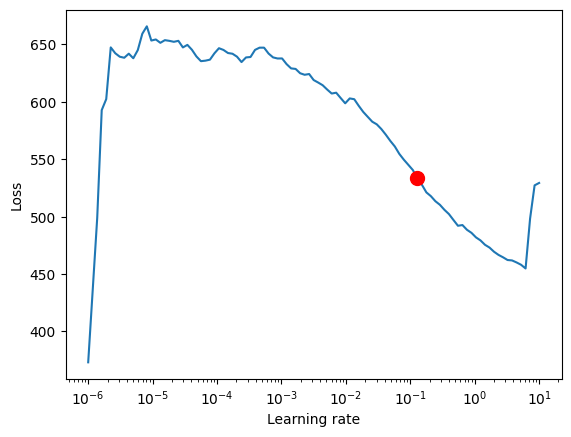

C:\Users\lvdburchard\AppData\Local\Temp\ipykernel_8980\2987656451.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [51]:
# Optional: Determine learning rate
if False:
    # configure network and trainer
    pl.seed_everything(42)
    trainer = pl.Trainer(
        accelerator="cpu",
        # clipping gradients is a hyperparameter and important to prevent divergance
        # of the gradient for recurrent neural networks
        gradient_clip_val=0.1,
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        # not meaningful for finding the learning rate but otherwise very important
        learning_rate=0.03,
        hidden_size=8,  # most important hyperparameter apart from learning rate
        # number of attention heads. Set to up to 4 for large datasets
        attention_head_size=4,
        dropout=0.1,  # between 0.1 and 0.3 are good values
        hidden_continuous_size=8,  # set to <= hidden_size
        loss=QuantileLoss(),
        optimizer="Ranger"
        # reduce learning rate if no improvement in validation loss after x epochs
        # reduce_on_plateau_patience=1000,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    res = Tuner(trainer).lr_find(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()


In [54]:

# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logging results to a tensorboard
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(quantiles = [0.5]),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 28.7k


c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.



In [55]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 573   
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 6.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 19: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s, v_num=20, train_loss_step=53.00, val_loss=102.0, train_loss_epoch=64.30]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 50/50 [00:17<00:00,  2.93it/s, v_num=20, train_loss_step=53.00, val_loss=102.0, train_loss_epoch=64.30]


In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
raw_predictions = best_tft.predict(test_dataloader, mode="raw", return_index=True)

In [59]:
# convert predictions to pd.DataFrame

def raw_preds_to_df(raw,idx_offset,quantiles = None):
    """
    raw is output of model.predict with return_index=True
    quantiles can be provided like [0.1,0.5,0.9] to get interpretable quantiles
    in the output, time_idx is the first prediction time index (one step after knowledge cutoff)
    pred_idx the index of the predicted date i.e. time_idx + h - 1
    """
    index = raw.index
    preds = raw.output.prediction
    dec_len = raw.output.prediction.shape[1]
    n_quantiles = preds.shape[-1]
    preds_df = pd.DataFrame(index.values.repeat(dec_len * n_quantiles, axis=0),columns=index.columns)
    preds_df = preds_df.assign(Horizon=np.tile(np.repeat(np.arange(1,1+dec_len),n_quantiles),len(preds_df)//(dec_len*n_quantiles)))
    preds_df = preds_df.assign(Quantile=np.tile(np.arange(n_quantiles),len(preds_df)//n_quantiles))
    preds_df = preds_df.assign(Prediction=preds.flatten().cpu().numpy())
    if quantiles is not None:
        preds_df['Quantile'] = preds_df['Quantile'].map({i:q for i,q in enumerate(quantiles)})

    preds_df['pred_idx'] = preds_df['time_idx'] + preds_df['Horizon'] - 1
    preds_df['Date'] = pd.to_datetime(idx_offset)
    preds_df['Date'] = preds_df['Date'] + preds_df['pred_idx'].apply(pd.DateOffset)
    return preds_df

pred = raw_preds_to_df(raw_predictions, first_date)
pred = pred.drop_duplicates() # for unknown reasons, predictions include many duplicated items
# default quantiles are  [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
# therefore, Quantile=3 is median
print(pred[lambda x: (x.Branch == "1") & (x.Group == "5") & (x.Horizon == 1)])

C:\Users\lvdburchard\AppData\Local\Temp\ipykernel_3600\859612390.py:23: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized.



     time_idx Branch Group  Horizon  Quantile   Prediction pred_idx  \
4140     2383      1     5        1         0  1450.474854     2383   
4143     2384      1     5        1         0  1476.666748     2384   
4146     2385      1     5        1         0  1413.289185     2385   
4149     2386      1     5        1         0  1597.752075     2386   
4152     2387      1     5        1         0  1770.060791     2387   
...       ...    ...   ...      ...       ...          ...      ...   
5160     2729      1     5        1         0  1454.532227     2729   
5163     2730      1     5        1         0  1697.468018     2730   
5166     2731      1     5        1         0  1656.275635     2731   
5169     2732      1     5        1         0  1753.103271     2732   
5172     2733      1     5        1         0  1420.174683     2733   

                     Date  
4140  2022-07-11 00:00:00  
4143  2022-07-12 00:00:00  
4146  2022-07-13 00:00:00  
4149  2022-07-14 00:00:00  
4152  2

In [60]:
sales = data[["Date", "Branch", "Group", "Sales"]].copy()
sales["Branch"] = sales["Branch"].apply(str)
sales["Group"] = sales["Group"].apply(str)
sales["Date"] = pd.to_datetime(sales["Date"], format="%Y-%m-%d")
pred["Date"] = pd.to_datetime(pred["Date"], format="%Y-%m-%d")

test = pd.merge(pred[["Date", "Branch", "Group", "Horizon", "Quantile", "Prediction"]], sales, how="inner", on=["Date", "Branch", "Group"])


evaluateMe = test[(test["Horizon"] == 1) & (test["Quantile"] == 0)]
WAPE = 100 * np.sum(np.abs(evaluateMe["Prediction"] - evaluateMe["Sales"])) / np.sum(evaluateMe["Sales"])
print(WAPE)


24.82123718541899


In [62]:

plotMe = evaluateMe[lambda x: (x.Branch == "1") & (x.Group == "1")]
plot = go.Figure()
plot.add_trace(go.Scatter(x=plotMe["Date"], y=plotMe["Sales"],name="Sales"))
plot.add_trace(go.Scatter(x=plotMe["Date"], y=plotMe["Prediction"],name="Prediction"))
plot.show()